### Libraries and Dataset

In [104]:
import numpy as np
import pandas as pd # data processing

import re
import string

import nltk # NLP
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.tokenize import word_tokenize
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('stopwords')

from sklearn.base import BaseEstimator, TransformerMixin # pipeline base
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer # text vectorizer
from sklearn.ensemble import RandomForestClassifier # modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score #generalization
from sklearn.model_selection import GridSearchCV #hyperparam tuning

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt # visualization
import seaborn as sns
sns.set_style('darkgrid')
from wordcloud import WordCloud
%matplotlib inline

from joblib import dump, load
import random
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xuan1113/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Preprocessing

In [2]:
# Define functions for cleaning.
def preprocess_text(text:str):
    """
    This utility function normalize a string by:
    - transforming in lowercase
    - expanding contractions
    - removing Usernames
    - removing links
    - removing hashtags
    - removing special/single characters
    - removing numbers 
    - removing multiple whitespaces
    - removing stopwords   
    - Stemming : suffix stripping
    - Lemmatization : get the root word
    
    
    Args:
        text (str): the input text you want to clean
        remove_stopwords (bool): whether or not to remove stopwords
    Returns:
        str: the cleaned text
    """

    # Convert all characters to lowercase
    text = text.lower()
    # Replacing contractions
    text = contractions.fix(text)
    # Remove username after @
    text = re.sub(r'@[^\s]+','',text)
    # Remove URLs
    text = re.sub(r"http\S+", '', text)
    # Remove hashtags
    text = re.sub(r'#[^\s]+', '', text)
    # Replace all the special characters and numbers with space
    text = re.sub(r"[^A-Za-z]+", ' ',text)
    # Remove all single characters
    text = re.sub(r'\s[a-zA-Z]\s', ' ',text)
    # Substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    # Stemming / Lemmatization / Remove stop words
    # Tokenize : breaking down sentence into word token.
    tokens = word_tokenize(text)
    # Check for stop words
    tokens = [w for w in tokens if w not in stopwords.words("english")]
    # Stemming
    ps = PorterStemmer()
    tokens = [ps.stem(w) for w in tokens]
    # Lemmatization
    wnetl = WordNetLemmatizer()
    tokens = [wnetl.lemmatize(w) for w in tokens]
    # Join cleaned words back together.
    text = " ".join(tokens)

    return text


In [134]:
def add_sentiment(text:str):
    """
    Function extract sentiment score from a text, value range from -1 to 1,
    where 1 is the most positive value, -1 otherwise.

    Args:
        text(str): input text to parse.
    
    Returns:
        sentiment(str): Positive or Negative or Neutral.
    """
    sia = SIA()
    if sia.polarity_scores(text)['compound'] > 0 :
        return 'POSITIVE'
    elif sia.polarity_scores(text)['compound'] == 0:
        return 'NEGATIVE'
    else:
        return 'NEUTRAL'


In [4]:
class Preprocessor(BaseEstimator, TransformerMixin):
    """
    This class is used as a pipeline and is inheriting from sklearn BaseEstimator and TransformerMixin
    This allows us to customize transforms and the final estimator that sklearn does not offer.
    We need to build this class to clean our train and test data as a pipeline transform.
    """
    def __init__(self):
        return None

    def fit(self, X=None):
        return self

    def transform(self, X=None):
        cleaned = X.apply(lambda x:preprocess_text(x))

        return cleaned


In [142]:
class SentimentAnalysis(BaseEstimator, TransformerMixin):
    """
    Class used to generate sentiment.
    """
    def __init__(self, add_senti:bool):
        self.add_senti = add_senti
        return None

    def fit(self, X=None):
        return self
        
    def transform(self, X=None):
        if self.add_senti:
            sentiment = X.apply(lambda x: add_sentiment(x))
            return pd.DataFrame({'text':X,'sentiment':sentiment})
        else:
            return X

### Data Extraction & cleaning

In [120]:
# Load training dataset.
train_df = pd.read_csv('Reddit_Data.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  37149 non-null  object
 1   category       37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB


In [121]:
train_df['category'].value_counts()

 1    15830
 0    13142
-1     8277
Name: category, dtype: int64

+ 0 Indicating it is a Neutral sentiment, 1 Indicating a postive sentiment, -1 Indicating a Negative sentiment. We only need to predict positive and negative sentiment, so neutral sentiment will be removed from the dataframe.

In [122]:
# Removing Neutral sentiments.
train_df = train_df[train_df.category != 0]

In [123]:
# Drop NAs
train_df = train_df.dropna(how='any')
# Rename column names
train_df.rename(columns={'clean_comment':'text'}, inplace=True)
train_df.rename(columns={'category':'label'}, inplace=True)
# Drop duplicate rows
train_df.drop_duplicates(subset='text', keep=False, inplace=True)

In [143]:
# Pipeline implementation
preprocess_pipeline = Pipeline(steps=[
    ('preprocess', Preprocessor()), # first step is to preprocess the text 
    ('sentiment', SentimentAnalysis(add_senti = False)) # second step obtains the sentiment of the text when add_senti=True
])
# Cleaning the training dataset.
train_set = train_df.copy()
train_set['text'] = preprocess_pipeline.fit_transform(X=train_df['text'])

In [125]:
# Explore the data frame.
print(train_set.info())
train_set['label'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23964 entries, 0 to 37247
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    23964 non-null  object
 1   label   23964 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 561.7+ KB
None


 1    15731
-1     8233
Name: label, dtype: int64

+ Now we have 2 columns in the dataframe - text and label. Label is the target column to predict.  The dataset is unbalanced as it contains more number of positive text compare to negative ones, we need to adjust them to even amount to make sure our model won't bias.

### Data Visualization

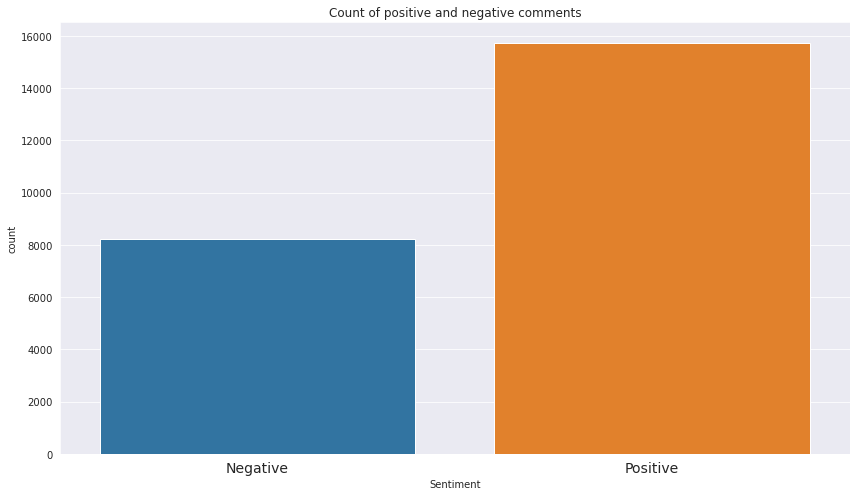

In [12]:
# Count the negative and positive comments.
plt.figure(figsize=(12,7))

sns.countplot(x='label',data = train_set)
plt.xticks(ticks=[0,1],labels=['Negative','Positive'], fontsize=14)
plt.xlabel('Sentiment')
plt.title("Count of positive and negative comments")
plt.tight_layout()
# The amount of positive comments is double the amount of negative comments.

In [13]:
# Generate word clouds to see word frequency in both positive and negative comments.
# Create text string for wordcloud function.
positive_col = train_set.groupby('label').get_group(1).text
negative_col = train_set.groupby('label').get_group(-1).text

positive_txt = ' '.join(positive_col)
negative_txt = ' '.join(negative_col)


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

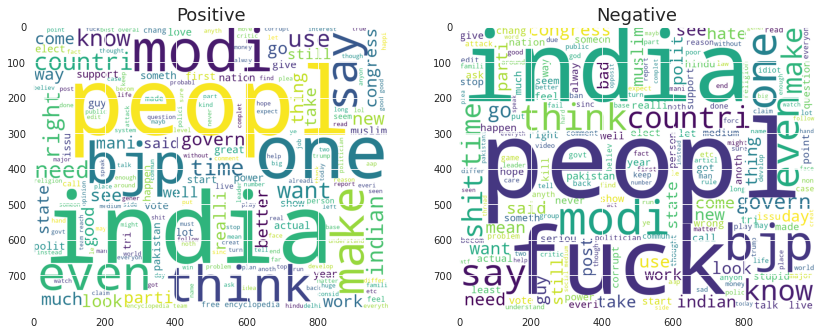

In [14]:
# Generate word cloud image.
positive_cloud = WordCloud(width=1000,height=800,background_color='white').generate(positive_txt)
negative_cloud = WordCloud(width=1000,height=800,background_color='white').generate(negative_txt)

# Display the genarated image.
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax[0].imshow(positive_cloud)
ax[0].set_title('Positive',fontsize=18)

ax[1].imshow(negative_cloud)
ax[1].set_title('Negative',fontsize=18)

plt.tight_layout

### Train, test, split

##### Balance the data. (The amount of the positive and negative sentiments must be equivalent to avoid bias.)

In [21]:
def balancer(df):
    positiveCount = len(train_set.groupby('label').get_group(1))
    negativeCount = len(train_set.groupby('label').get_group(-1))

    if positiveCount > negativeCount:
        final = pd.concat([df[df.label==1].sample(negativeCount),df[df.label==-1]])
    else:
        final = pd.concat([df[df.label==-1].sample(negativeCount),df[df.label==1]])

    return final.sample(frac=1).reset_index(drop=True)

final_df = balancer(train_set)

In [25]:
print(final_df.info())
final_df.label.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16466 entries, 0 to 16465
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16466 non-null  object
 1   label   16466 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 257.4+ KB
None


-1    8233
 1    8233
Name: label, dtype: int64

In [27]:
# split the data.
X_train, X_test, y_train, y_test = train_test_split(final_df['text'], final_df['label'], test_size=0.20, random_state=1)

### Model Training

In [39]:
# We will now vectorize using TF-IDF technique to transform text into a meaningful representation of numbers which is used to fit machine algorithms for prediction.
# Random Forest will be used as the first model.
vectorizer = TfidfVectorizer()
vect_train = vectorizer.fit_transform(X_train)
vect_test = vectorizer.transform(X_test)

rf = RandomForestClassifier(random_state=1)
# fit
rf.fit(vect_train, y_train)
# predict
predict_rf = rf.predict(vect_test)

# performance
print("Classification Report: \n", classification_report(y_test, predict_rf,target_names=['Negative','Positive']))
print("Confusion Matrix: \n", confusion_matrix(y_test, predict_rf))
print("Accuracy: \n", accuracy_score(y_test, predict_rf))

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.83      0.82      0.82      1674
    Positive       0.81      0.82      0.82      1620

    accuracy                           0.82      3294
   macro avg       0.82      0.82      0.82      3294
weighted avg       0.82      0.82      0.82      3294

Confusion Matrix: 
 [[1372  302]
 [ 290 1330]]
Accuracy: 
 0.8202792956891317


In [40]:
print(rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [48]:
# Tuning hyperparameters
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 90, stop = 110, num = 5)]
# Maximum number of levels in tree
max_depth = [None, 2]
# Minimum number of samples required to split a node
min_samples_split = [1, 3]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [49]:
# Parameter grid preparetion for tuning
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [90, 95, 100, 105, 110], 'max_depth': [None, 2], 'min_samples_split': [1, 3], 'bootstrap': [True, False]}


In [50]:
# Tuning with GridSearchCV
rf_Grid = GridSearchCV(estimator = rf, param_grid = param_grid, verbose=1)
rf_Grid.fit(vect_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False], 'max_depth': [None, 2],
                         'min_samples_split': [1, 3],
                         'n_estimators': [90, 95, 100, 105, 110]},
             verbose=1)

In [52]:
rf_Grid.best_params_

{'bootstrap': False,
 'max_depth': None,
 'min_samples_split': 3,
 'n_estimators': 100}

In [53]:
# adjust parameter grid
param_grid1 = {'n_estimators': [98,100,102],
               'max_depth': [None],
               'min_samples_split': [2,3],
               'bootstrap': [False]}

In [55]:
# tuning with adjusted param grid
rf_Grid1 = GridSearchCV(estimator = rf, param_grid = param_grid1, verbose=1)
rf_Grid1.fit(vect_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [False], 'max_depth': [None],
                         'min_samples_split': [2, 3],
                         'n_estimators': [98, 100, 102]},
             verbose=1)

In [70]:
# let's see the performance after tuning
predict_rftune = rf_Grid1.predict(vect_test)
print("Classification Report: \n", classification_report(y_test, predict_rftune,target_names=['Negative','Positive']))
print("Confusion Matrix: \n", confusion_matrix(y_test, predict_rftune))
print("Accuracy: \n", accuracy_score(y_test, predict_rftune))
# improvement in accuracy
print('Improvement of {:0.2f}%.'.format((accuracy_score(y_test, predict_rftune)-accuracy_score(y_test, predict_rf))/accuracy_score(y_test, predict_rf)*100))


Classification Report: 
               precision    recall  f1-score   support

    Negative       0.85      0.83      0.84      1674
    Positive       0.82      0.85      0.84      1620

    accuracy                           0.84      3294
   macro avg       0.84      0.84      0.84      3294
weighted avg       0.84      0.84      0.84      3294

Confusion Matrix: 
 [[1382  292]
 [ 249 1371]]
Accuracy: 
 0.8357619914996964
Improvement of 1.89%.


We achieved an improvement in accuracy of 1.89% after tuning.

In [80]:
# Now let's fit the data to logistic regression model.
lr=LogisticRegression(random_state=1)
#Fitting
lr.fit(vect_train,y_train)
# Predict
lr_pred=lr.predict(vect_test)

# Performance
print("Classification Report: \n", classification_report(y_test, lr_pred,target_names=['Negative','Positive']))
print("Confusion Matrix: \n", confusion_matrix(y_test, lr_pred))
print("Accuracy: \n", accuracy_score(y_test, lr_pred))

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.84      0.84      0.84      1674
    Positive       0.83      0.83      0.83      1620

    accuracy                           0.84      3294
   macro avg       0.84      0.84      0.84      3294
weighted avg       0.84      0.84      0.84      3294

Confusion Matrix: 
 [[1406  268]
 [ 270 1350]]
Accuracy: 
 0.8366727383120826


In [81]:
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 1,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [98]:
# parameter grid for tuning.
lrparam_grid = {
    'penalty':['l1', 'l2', 'elasticnet', 'none'],
    'C':np.logspace(-4,4,8),
    'solver':['sag','saga','lbfgs']

}

In [99]:
# Tuning with Grid Search.
lr_Grid = GridSearchCV(estimator = lr, param_grid = lrparam_grid, verbose=1)
lr_Grid.fit(vect_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(estimator=LogisticRegression(random_state=1),
             param_grid={'C': array([1.00000000e-04, 1.38949549e-03, 1.93069773e-02, 2.68269580e-01,
       3.72759372e+00, 5.17947468e+01, 7.19685673e+02, 1.00000000e+04]),
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['sag', 'saga', 'lbfgs']},
             verbose=1)

In [101]:
# let's see the performance after tuning
predict_lrtune = lr_Grid.predict(vect_test)
print("Classification Report: \n", classification_report(y_test, predict_lrtune,target_names=['Negative','Positive']))
print("Confusion Matrix: \n", confusion_matrix(y_test, predict_lrtune))
print("Accuracy: \n", accuracy_score(y_test, predict_lrtune))

# improvement in accuracy
print('Improvement of {:0.2f}%.'.format((accuracy_score(y_test, predict_lrtune)-accuracy_score(y_test, lr_pred))/accuracy_score(y_test, lr_pred)*100))

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.86      0.85      0.85      1674
    Positive       0.85      0.85      0.85      1620

    accuracy                           0.85      3294
   macro avg       0.85      0.85      0.85      3294
weighted avg       0.85      0.85      0.85      3294

Confusion Matrix: 
 [[1426  248]
 [ 238 1382]]
Accuracy: 
 0.8524590163934426
Improvement of 1.89%.


The logistic regression model get an improvement in accuracy of 1.89% after grid search tuning, and it is the best model with accuracy of 0.852 compare to random forest model, it will be used for classification on the test data set that we scrapped earlier on Reddit.

#### Save the chosen model.

In [162]:
#model pipeline.
model_pipeline = Pipeline(steps =[
    ('vect',TfidfVectorizer()),
    ('logistic',lr_Grid.best_estimator_)
])
model_pipeline.fit(X_train,y_train)
dump(model_pipeline,'model.pkl')
final_model = load('model.pkl')

### Predicting reddit test data

In [169]:
# Read in test dataset.
raw_data = pd.read_csv('New York sues Donald Trump, company and family members over widespread fraud claims, seeks at least $250 million in penalties.csv')
test = raw_data.copy()
test.head(5)

,comment
0,TLDR: \n\n+ Civil Suit\n+ Alleges Trump of fra...
1,">\tMar-a-Lago ""generated less than $25 million..."
2,I don’t quite understand how someone can be af...
3,The same people who stole money from cancer ch...
4,And this is how he'll be forced to admit he's ...


In [170]:
# Some cleaning.
# Drop NAs
test = test.dropna(how='any')

# Drop duplicate rows
test.drop_duplicates(subset='comment', keep=False, inplace=True)

# alter preprocessing pipeline parameter
preprocess_pipeline.set_params(**{'sentiment__add_senti':True})

# Cleaning the test dataset.
test = preprocess_pipeline.fit_transform(X=test['comment'])
test.head()

,text,sentiment
0,tldr civil suit alleg trump fraud span year in...,NEUTRAL
1,mar lago gener le million annual revenu suit s...,NEGATIVE
2,quit understand someon affili mani convict peo...,NEUTRAL
3,peopl stole money cancer chariti would never c...,NEUTRAL
4,forc admit broke,NEUTRAL


In [171]:
# sentimentIntensityAnalyzer returns three categories(POSTIVE,NEGATIVE,NEUTRAL), removing Neutral sentiments.
test = test[test.sentiment != 'NEUTRAL']
# Convert labels to numeric forms.
test['sentiment'] = test['sentiment'].replace({'POSITIVE':1,'NEGATIVE':-1})
test.head()

,text,sentiment
1,mar lago gener le million annual revenu suit s...,-1
5,bank loan money without due dilig scrutini bla...,1
6,million damag good thing got billion saudi hel...,1
7,dear maga love one come ask money pay legal bi...,1
8,trump fals inflat net worth billion dollar jam...,1


In [172]:
# Predicting each comment
test['prediction'] = final_model.predict(test.text)
test.head()

,text,sentiment,prediction
1,mar lago gener le million annual revenu suit s...,-1,1
5,bank loan money without due dilig scrutini bla...,1,-1
6,million damag good thing got billion saudi hel...,1,1
7,dear maga love one come ask money pay legal bi...,1,1
8,trump fals inflat net worth billion dollar jam...,1,-1


In [177]:
# the accuracy score of sentimentIntensityAnalyzer and our model.
accuracy_score(test.sentiment, test.prediction)

0.5961538461538461